In [1]:
import os
import sys
import glob

import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import copy
import dill
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader,random_split, Subset, ConcatDataset
from tqdm import tqdm

import tsgm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sys.path.append(os.path.abspath('..'))
from GP import *
from Models.GPVAE_pendulum import GPVAE
from Models.PIVAE_pendulum import PIVAE
from Models.PIGPVAE_pendulum import PIGPVAE
from metrics import *

import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file

warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)


In [2]:
class PendulumDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.unique_intervals = df['interval'].unique()

    def __len__(self):
        return len(self.unique_intervals)

    def __getitem__(self, idx):
        batch = self.unique_intervals[idx]
        id = self.df['interval'] == batch
        theta = torch.tensor(self.df[id]['theta'].to_numpy(), dtype=torch.float32)
        t = torch.tensor(self.df[id]['t'].to_numpy(), dtype=torch.float32)  # Normalize time

        # Concatenate theta and t as input batch
        x_batch = torch.cat((theta.unsqueeze(1), t.unsqueeze(1)), axis=1)
        return x_batch # Also return omega for plotting

# Load the dataset
df_damped = pd.read_csv("../Data/damped_pendulum_data.csv")
df_damped['interval'] = df_damped['omega'].astype('category').cat.codes
df_damped['theta'] = df_damped['theta']

dataset = PendulumDataset(df_damped)

train_ratio = 0.7
test_ratio = 1-train_ratio

# Calculate split sizes
total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

seed = 42
generator = torch.Generator().manual_seed(seed)

# Split the dataset
train_subset, test_subset = random_split(
    dataset,
    [train_size, test_size],
    generator=generator
)
train_loader = DataLoader(train_subset, batch_size=1, shuffle=False)
val_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

## Load Models (GPVAE, PIVAE, PIGPVAE, timeGAN, timeVQVAE)

In [3]:
# GPVAE
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
GPVAE_model = GPVAE(GP_inf = GP_inference(kernel), 
              activation_decoder=nn.ReLU(),
              hidden_layers_encoder=[10])
GPVAE_model.load_state_dict(torch.load('pre_trained_models/GPVAE_pendulum.pth'))

<All keys matched successfully>

In [4]:
# PIGPVAE
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5)) 
GP_inf = GP_inference(kernel)
PIGPVAE_model = PIGPVAE(GP_inf=GP_inf, 
                        hidden_layers_encoder_delta=[10,10], 
                        hidden_layers_encoder_phy=[10], 
                        hidden_layers_decoder_delta=[10,10],
                        activation_decoder_delta=nn.ReLU(),
                        initial_alpha=4,
                        trainable_alpha=True,
                        mu_prior=torch.tensor(1.7), var_prior=torch.tensor(1))
PIGPVAE_model.load_state_dict(torch.load('pre_trained_models/PIGPVAE_pendulum.pth'))

<All keys matched successfully>

In [5]:
PIVAE_model = PIVAE(hidden_layers=[10], 
              activation=nn.Tanh(),
              mu_prior=torch.tensor(0),
              var_prior=torch.tensor(2.0))
PIVAE_model.load_state_dict(torch.load('pre_trained_models/PIVAE_pendulum.pth'))

<All keys matched successfully>

In [6]:
with open('pre_trained_models/timegan_pendulum.pkl', 'rb') as f:
    timeGAN_model = dill.load(f)


In [7]:
t_uni=torch.tensor(df_damped[df_damped['interval']==0]['t'])
t_uni = t_uni.to(torch.float32)

## Compute Maximum Mean Discrepancy over 100 synthetic datasets for each method

### GPVAE MMD 

In [8]:
full_data = DataLoader(dataset)
original_data_list = []
for batch in full_data:
    # Each batch is expected to be of shape [24, 1]
    # Add to the list
    original_data_list.append(batch[0][:,0])

# Stack to create a tensor of shape [total_samples, 24, 1]
original_data = torch.stack(original_data_list)
original_data = original_data.unsqueeze(-1)

In [9]:
# GPVAE generation related quantities
q_mu_l=[]
for x_batch in train_loader:
    with torch.no_grad():
        # Pass the batch through the GPVAE_model
        _, _, _, _, q_mu_i, _ = GPVAE_model(x_batch.squeeze())  
        q_mu_l.append(q_mu_i)
mu_s_GPVAE = torch.cat(q_mu_l, dim=1).mean(dim=1).unsqueeze(1)

In [10]:
ns = total_size

In [11]:
# Initialize metric storage
mmd_values = []
correlation_metrics = []
mdd_values = []

# Number of generated datasets
num_datasets = 100

# Torch manual seed for reproducibility
torch.manual_seed(0)

# Instantiate the metrics class
metrics = SyntheticDataMetrics()

# Loop to generate datasets and compute metrics
for i in range(num_datasets):
    # Generate synthetic data
    gd_l_GPVAE, _ = GPVAE_model.generate_and_plot(mu_s_GPVAE, t_uni, ns, (-1.5, 1.5), df_damped, plot=False, seed=i)
    
    # Stack the generated data into a tensor
    Gd_GPVAE = torch.stack(gd_l_GPVAE)
    
    # Compute MMD metric
    mmd_value = metrics.compute_mmd(original_data, Gd_GPVAE)
    mmd_values.append(mmd_value)
    
    # Compute Correlation Metric
    correlation_metric_value = metrics.correlation_metric(original_data, gd_l_GPVAE)
    correlation_metrics.append(correlation_metric_value)
    
    # Compute MDD
    mdd_value = metrics.compute_mdd(original_data, gd_l_GPVAE)
    mdd_values.append(mdd_value)

# Convert lists to tensors for further processing
mmd_GPVAE_tensor = torch.tensor(mmd_values)
correlation_metric_GPVAE_tensor = torch.tensor(correlation_metrics)
mdd_metric_GPVAE_tensor = torch.tensor(mdd_values)

# Print min and max for each metric
print("MMD - Min:", mmd_GPVAE_tensor.min().item(), "Max:", mmd_GPVAE_tensor.max().item())
print("Correlation Metric - Min:", correlation_metric_GPVAE_tensor.min().item(), "Max:", correlation_metric_GPVAE_tensor.max().item())
print("MDD - Min:", mdd_metric_GPVAE_tensor.min().item(), "Max:", mdd_metric_GPVAE_tensor.max().item())


MMD - Min: 0.2321252077817917 Max: 0.3452049046754837
Correlation Metric - Min: 238.1227264404297 Max: 259.19830322265625
MDD - Min: 0.02485000069881797 Max: 0.0362500004450278


### PIVAE MMD 

In [12]:
x_hat, mu, var = {}, {}, {}
for x_batch in train_loader:
    with torch.no_grad():
        x_batch = x_batch.squeeze(0)  # Remove the batch dimension if necessary
        x_hat[x_batch], mu[x_batch], var[x_batch] = PIVAE_model(x_batch)

mu_tensor = torch.cat([mu[batch] for batch in mu.keys()], dim=0)
var_tensor = torch.cat([var[batch] for batch in var.keys()], dim=0)
mu_PIVAE_post = mu_tensor.mean()
var_PIVAE_post = var_tensor.mean()

### PIGPVAE MMD 

In [13]:
q_mu_delta_l,  q_mu_phy_l, q_var_phy_l = [], [], []

# Iterate through the train_loader_GPVAE to obtain x_batch
for x_batch in train_loader:
    with torch.no_grad():
        x_batch = x_batch.squeeze(0)  # Remove the batch dimension if necessary

        # Forward pass through the model
        _, _, _, _, _, _, q_mu_delta_i, _, q_mu_phy_i, q_var_phy_i = PIGPVAE_model(x_batch)

        # Append the required quantities
        q_mu_delta_l.append(q_mu_delta_i)
        q_mu_phy_l.append(q_mu_phy_i)
        q_var_phy_l.append(q_var_phy_i)

mean_q_mu_phy = sum(q_mu_phy_l) / len(q_mu_phy_l)
mean_q_var_phy = sum(q_var_phy_l) / len(q_var_phy_l)

mu_s_PIGPVAE = torch.cat(q_mu_delta_l, dim=1).mean(dim=1).unsqueeze(1)


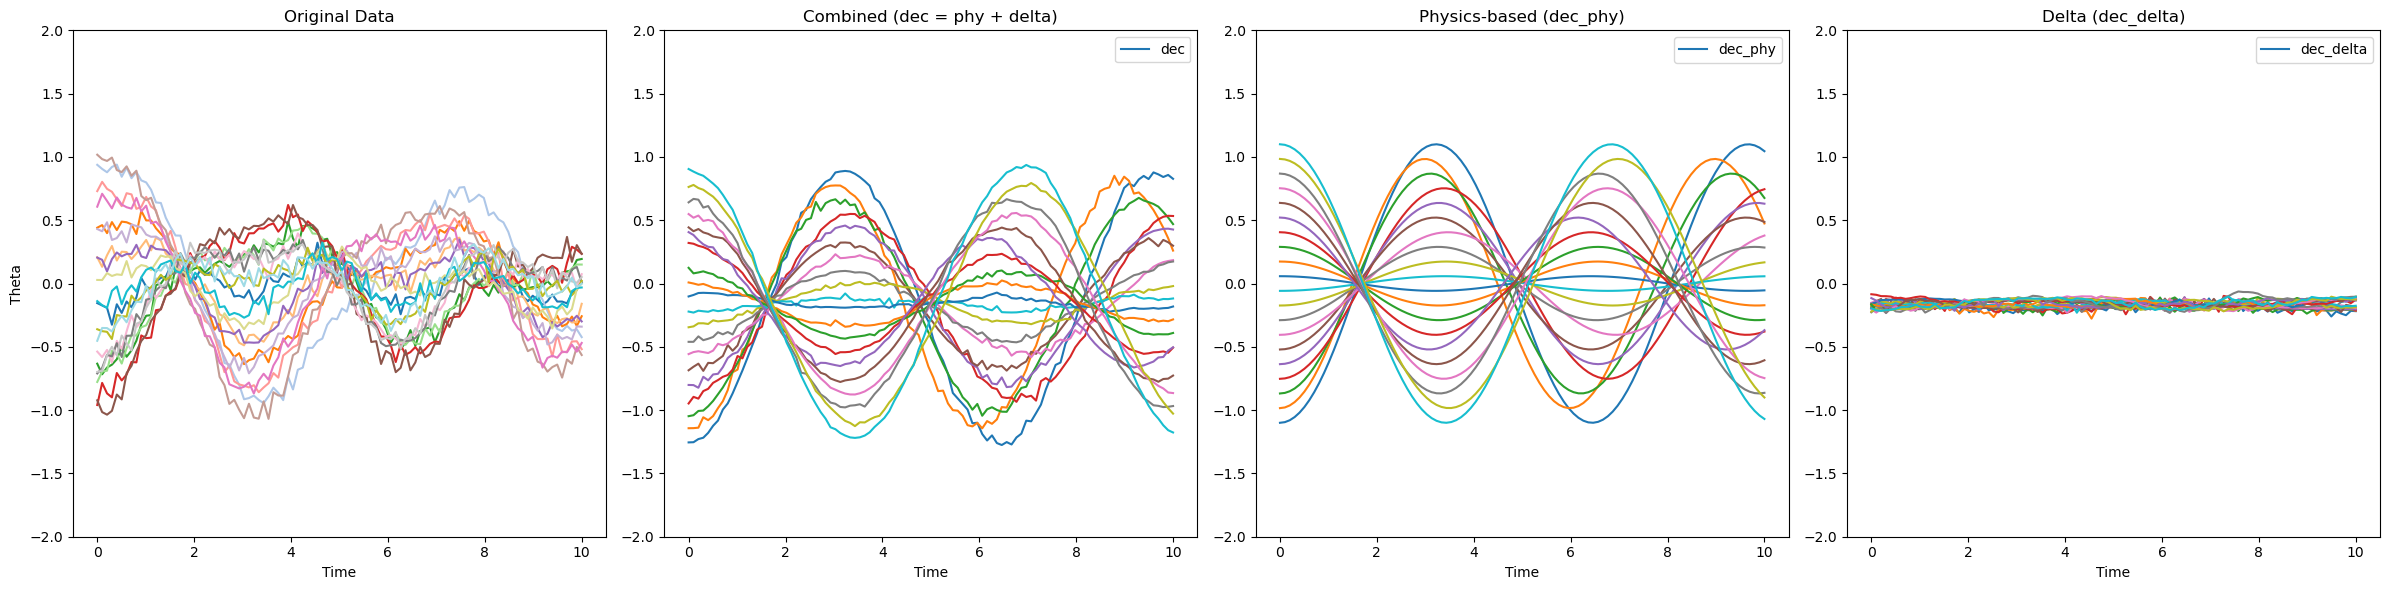

In [14]:
ns = total_size
T0 = torch.linspace(-1.1,1.1,ns)
unique_intervals = df_damped['interval'].unique()
num_unique_intervals = len(unique_intervals)
k_values, gd_l_PIGPVAE, fig, axs=PIGPVAE_model.generate_and_plot(mu_s_PIGPVAE, 
                        mean_q_mu_phy, 
                        mean_q_var_phy,
                        df=df_damped,
                        num_unique_intervals=num_unique_intervals, 
                        ns=ns,                            
                        T0=T0, 
                        t_uni=t_uni, 
                        axs_ylim=(-2, 2),
                        plot=True,
                        seed=0
                       )
Gd_PIGPVAE = torch.stack(gd_l_PIGPVAE)

In [15]:
# Initialize metric storage
mmd_PIGPVAE_values = []
correlation_metrics_PIGPVAE = []
mdd_values_PIGPVAE = []

# Set parameters for synthetic data generation
num_datasets = 100
T0 = torch.linspace(-1.1,1.1,ns)

for i in range(num_datasets):

    # Generate synthetic data
    k_values, gd_l_PIGPVAE, fig, axs = PIGPVAE_model.generate_and_plot(
        mu_s_PIGPVAE, 
        mean_q_mu_phy, 
        mean_q_var_phy,
        df=df_damped,
        num_unique_intervals=num_unique_intervals, 
        ns=ns,
        T0=T0,
        t_uni=t_uni,
        axs_ylim=(-2, 2),
        plot=False,
        seed=i)
    
    # Stack generated data
    Gd_PIGPVAE = torch.stack(gd_l_PIGPVAE)
    
    # Compute MMD
    mmd_value = metrics.compute_mmd(original_data, Gd_PIGPVAE)
    mmd_PIGPVAE_values.append(mmd_value)
    
    # Compute Correlation Metric
    correlation_metric_value = metrics.correlation_metric(original_data, gd_l_PIGPVAE)
    correlation_metrics_PIGPVAE.append(correlation_metric_value)
    
    # Compute MDD
    mdd_value = metrics.compute_mdd(original_data, gd_l_PIGPVAE)
    mdd_values_PIGPVAE.append(mdd_value)

# Convert lists to tensors for further processing
mmd_PIGPVAE_tensor = torch.tensor(mmd_PIGPVAE_values)
correlation_metric_PIGPVAE_tensor = torch.tensor(correlation_metrics_PIGPVAE)
mdd_metric_PIGPVAE_tensor = torch.tensor(mdd_values_PIGPVAE)

# Print min and max for each metric
print("PIGPVAE Metrics:")
print("MMD - Min:", mmd_PIGPVAE_tensor.min().item(), "Max:", mmd_PIGPVAE_tensor.max().item())
print("Correlation Metric - Min:", correlation_metric_PIGPVAE_tensor.min().item(), "Max:", correlation_metric_PIGPVAE_tensor.max().item())
print("MDD - Min:", mdd_metric_PIGPVAE_tensor.min().item(), "Max:", mdd_metric_PIGPVAE_tensor.max().item())

PIGPVAE Metrics:
MMD - Min: 0.21951840445399284 Max: 0.24664390087127686
Correlation Metric - Min: 326.74908447265625 Max: 359.53472900390625
MDD - Min: 0.024753295452645645 Max: 0.027773226869357452


In [16]:
# Initialize metric storage
mmd_PIVAE_values = []
correlation_metrics_PIVAE = []
mdd_values_PIVAE = []

# Number of datasets to generate
num_datasets = 100
min_T, max_T = 15, 30
y0_val = T0

# Loop to generate datasets and compute metrics
for i in range(num_datasets):
    torch.manual_seed(i)  # Set seed for reproducibility
    
    # Generate synthetic data using PIVAE model
    gd_l_PIVAE, _ = PIVAE_model.generate(mu_PIVAE_post, var_PIVAE_post, y0_val, t_uni)
    
    # Stack generated data
    Gd_PIVAE = torch.stack(gd_l_PIVAE)
    
    # Compute MMD
    mmd_value = metrics.compute_mmd(original_data, Gd_PIVAE)
    mmd_PIVAE_values.append(mmd_value)
    
    # Compute Correlation Metric
    correlation_metric_value = metrics.correlation_metric(original_data, gd_l_PIVAE)
    correlation_metrics_PIVAE.append(correlation_metric_value)
    
    # Compute MDD
    mdd_value = metrics.compute_mdd(original_data, gd_l_PIVAE)
    mdd_values_PIVAE.append(mdd_value)

# Convert lists to tensors for further processing
mmd_PIVAE_tensor = torch.tensor(mmd_PIVAE_values)
correlation_metric_PIVAE_tensor = torch.tensor(correlation_metrics_PIVAE)
mdd_metric_PIVAE_tensor = torch.tensor(mdd_values_PIVAE)

# Compute and print min and max values for each metric
print(f"Min MMD: {mmd_PIVAE_tensor.min().item()}, Max MMD: {mmd_PIVAE_tensor.max().item()}")
print(f"Min Correlation Metric: {correlation_metric_PIVAE_tensor.min().item()}, Max Correlation Metric: {correlation_metric_PIVAE_tensor.max().item()}")
print(f"Min MDD: {mdd_metric_PIVAE_tensor.min().item()}, Max MDD: {mdd_metric_PIVAE_tensor.max().item()}")


Min MMD: 0.1651042327284813, Max MMD: 0.21260681375861168
Min Correlation Metric: 244.4665069580078, Max Correlation Metric: 298.1757507324219
Min MDD: 0.015873784878118625, Max MDD: 0.021425883735006434


In [17]:

in_path = "TimeGAN_gen.npz"

data = np.load("TimeGAN_gen.npz")
all_synth = data["all_synth"]  # shape: (num_datasets, ns, T, features)

mmd_vals       = []
corr_vals      = []
mdd_vals       = []

for raw in all_synth:
    # raw.shape == (ns, T, features)
    # Convert each sample to torch.Tensor
    gd_list = [torch.tensor(raw[i]) for i in range(raw.shape[0])]
    Gd      = torch.stack(gd_list)  # shape: (ns, T, features)
    
    # Compute metrics
    mmd_vals.append( metrics.compute_mmd(original_data, Gd) )
    corr_vals.append(metrics.correlation_metric(original_data, gd_list))
    mdd_vals.append( metrics.compute_mdd(original_data, gd_list) )

Gd_timeGAN = Gd
# 2d) Convert to tensors and report
mmd_timeGAN_tensor   = torch.tensor(mmd_vals)
correlation_metric_timeGAN_tensor  = torch.tensor(corr_vals)
mdd_metric_timeGAN_tensor   = torch.tensor(mdd_vals)

print(f"Min MMD: {mmd_timeGAN_tensor.min().item()},  Max MMD: {mmd_timeGAN_tensor.max().item()}")
print(f"Min Corr: {correlation_metric_timeGAN_tensor.min().item()}, Max Corr: {correlation_metric_timeGAN_tensor.max().item()}")
print(f"Min MDD: {mdd_metric_timeGAN_tensor.min().item()},  Max MDD: {mdd_metric_timeGAN_tensor.max().item()}")



Min MMD: 0.38786745071411133,  Max MMD: 0.5220221541821957
Min Corr: 185.96792602539062, Max Corr: 301.46826171875
Min MDD: 0.055150000106996444,  Max MDD: 0.05989999964892205


In [18]:
"""# Initialize metric storage
mmd_timeGAN_values = []
correlation_metrics_timeGAN = []
mdd_values_timeGAN = []

# Number of generated datasets
num_datasets = 100
tf.random.set_seed(42)

# Loop to generate datasets and compute metrics
for i in range(num_datasets):
    # Generate synthetic data
    gd_l_timeGAN = timeGAN_model.generate(n_samples=ns)
    gd_l_timeGAN = [torch.tensor(gd_l_timeGAN[i]) for i in range(gd_l_timeGAN.shape[0])]
    
    # Stack the generated data into a tensor
    Gd_timeGAN = torch.stack(gd_l_timeGAN)
    
    # Compute MMD metric
    mmd_value = metrics.compute_mmd(original_data, Gd_timeGAN)
    mmd_timeGAN_values.append(mmd_value)
    
    # Compute Correlation Metric
    correlation_metric_value = metrics.correlation_metric(original_data, gd_l_timeGAN)
    correlation_metrics_timeGAN.append(correlation_metric_value)
    
    # Compute MDD
    mdd_value = metrics.compute_mdd(original_data, gd_l_timeGAN)
    mdd_values_timeGAN.append(mdd_value)

# Convert lists to tensors for further processing
mmd_timeGAN_tensor = torch.tensor(mmd_timeGAN_values)
correlation_metric_timeGAN_tensor = torch.tensor(correlation_metrics_timeGAN)
mdd_metric_timeGAN_tensor = torch.tensor(mdd_values_timeGAN)

# Compute and print min and max values for each metric
print(f"Min MMD: {mmd_timeGAN_tensor.min().item()}, Max MMD: {mmd_timeGAN_tensor.max().item()}")
print(f"Min Correlation Metric: {correlation_metric_timeGAN_tensor.min().item()}, Max Correlation Metric: {correlation_metric_timeGAN_tensor.max().item()}")
print(f"Min MDD: {mdd_metric_timeGAN_tensor.min().item()}, Max MDD: {mdd_metric_timeGAN_tensor.max().item()}")
"""

'# Initialize metric storage\nmmd_timeGAN_values = []\ncorrelation_metrics_timeGAN = []\nmdd_values_timeGAN = []\n\n# Number of generated datasets\nnum_datasets = 100\ntf.random.set_seed(42)\n\n# Loop to generate datasets and compute metrics\nfor i in range(num_datasets):\n    # Generate synthetic data\n    gd_l_timeGAN = timeGAN_model.generate(n_samples=ns)\n    gd_l_timeGAN = [torch.tensor(gd_l_timeGAN[i]) for i in range(gd_l_timeGAN.shape[0])]\n    \n    # Stack the generated data into a tensor\n    Gd_timeGAN = torch.stack(gd_l_timeGAN)\n    \n    # Compute MMD metric\n    mmd_value = metrics.compute_mmd(original_data, Gd_timeGAN)\n    mmd_timeGAN_values.append(mmd_value)\n    \n    # Compute Correlation Metric\n    correlation_metric_value = metrics.correlation_metric(original_data, gd_l_timeGAN)\n    correlation_metrics_timeGAN.append(correlation_metric_value)\n    \n    # Compute MDD\n    mdd_value = metrics.compute_mdd(original_data, gd_l_timeGAN)\n    mdd_values_timeGAN.append

In [19]:
# Initialize metric storage
mmd_TimeVQVAE_values = []
correlation_metrics_TimeVQVAE = []
mdd_values_TimeVQVAE = []
# Loop to generate datasets and compute metrics
# Specify the folder containing CSV files
folder_path = 'TimeVQVAE_gen_data/Data100/generated_sets'

# Use glob to get all CSV file paths
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# List to store the tensors for each DataFrame
TimeVQVAE_tensors_list = []

# Process each CSV file
for i, file in enumerate(csv_files):
    # Load the DataFrame
    df = pd.read_csv(file, header=None)
    
    # Convert each row to a PyTorch tensor of size [24, 1]
    tensor_list = [torch.tensor(row.values, dtype=torch.float32).view(100, 1) for _, row in df.iterrows()]
    
    Gd_TimeVQVAE = torch.stack(tensor_list)
    # Add the list of tensors to the overall list
    TimeVQVAE_tensors_list.append(Gd_TimeVQVAE)
    
    
    # Compute MMD
    mmd_value = metrics.compute_mmd(original_data, Gd_TimeVQVAE)
    mmd_TimeVQVAE_values.append(mmd_value)
    
    # Compute Correlation Metric
    correlation_metric_value = metrics.correlation_metric(original_data, Gd_TimeVQVAE)
    correlation_metrics_TimeVQVAE.append(correlation_metric_value)
    
    # Compute MDD
    mdd_value = metrics.compute_mdd(original_data, Gd_TimeVQVAE)
    mdd_values_TimeVQVAE.append(mdd_value)

# Convert lists to tensors for further processing
mmd_TimeVQVAE_tensor = torch.tensor(mmd_TimeVQVAE_values)
correlation_metric_TimeVQVAE_tensor = torch.tensor(correlation_metrics_TimeVQVAE)
mdd_metric_TimeVQVAE_tensor = torch.tensor(mdd_values_TimeVQVAE)

# Compute and print min and max values for each metric
print(f"Min MMD: {mmd_TimeVQVAE_tensor.min()}, Max MMD: {mmd_TimeVQVAE_tensor.max()}")
print(f"Min Correlation Metric: {correlation_metric_TimeVQVAE_tensor.min()}, Max Correlation Metric: {correlation_metric_TimeVQVAE_tensor.max()}")
print(f"Min MDD: {mdd_metric_TimeVQVAE_tensor.min()}, Max MDD: {mdd_metric_TimeVQVAE_tensor.max()}")


Min MMD: 0.20109959645196795, Max MMD: 0.21061705448664725
Min Correlation Metric: 229.26126098632812, Max Correlation Metric: 267.711669921875
Min MDD: 0.018792203306147618, Max MDD: 0.02894028868448779


In [20]:
# Provided tensors
mmd_tensors = {
    "PIGPVAE": mmd_PIGPVAE_tensor,
    "PIVAE": mmd_PIVAE_tensor,
    "GPVAE": mmd_GPVAE_tensor,
    "TimeGAN": mmd_timeGAN_tensor,
    "TimeVQVAE": mmd_TimeVQVAE_tensor
}
correlation_tensors = {
    "PIGPVAE": correlation_metric_PIGPVAE_tensor,
    "PIVAE": correlation_metric_PIVAE_tensor,
    "GPVAE": correlation_metric_GPVAE_tensor,
    "TimeGAN": correlation_metric_timeGAN_tensor,
    "TimeVQVAE": correlation_metric_TimeVQVAE_tensor
}
mdd_tensors = {
    "PIGPVAE": mdd_metric_PIGPVAE_tensor,
    "PIVAE": mdd_metric_PIVAE_tensor,
    "GPVAE": mdd_metric_GPVAE_tensor,
    "TimeGAN": mdd_metric_timeGAN_tensor,
    "TimeVQVAE": mdd_metric_TimeVQVAE_tensor
}

# Combine all metrics into a single table
combined_results = {
    "Model": list(mmd_tensors.keys()),
    "MMD Mean (Std)": [
        f"{tensor.mean().item():.4f} ({tensor.std().item():.4f})" for tensor in mmd_tensors.values()
    ],
    "Correlation Mean (Std)": [
        f"{tensor.mean().item():.4f} ({tensor.std().item():.4f})" for tensor in correlation_tensors.values()
    ],
    "MDD Mean (Std)": [
        f"{tensor.mean().item():.4f} ({tensor.std().item():.4f})" for tensor in mdd_tensors.values()
    ],
}

# Create a DataFrame for combined results
combined_results_df = pd.DataFrame(combined_results)

# Export the DataFrame to LaTeX format
latex_output = combined_results_df.to_latex(index=False)

# Save the LaTeX table
# with open("tables/Metrics_heating.tex", "w") as f:
    # f.write(latex_output)

# Display the formatted table
print("Combined Metrics Results:")
print(combined_results_df)


Combined Metrics Results:
       Model   MMD Mean (Std) Correlation Mean (Std)   MDD Mean (Std)
0    PIGPVAE  0.2344 (0.0058)      349.0826 (6.1459)  0.0264 (0.0007)
1      PIVAE  0.1902 (0.0081)     271.6409 (10.8462)  0.0179 (0.0010)
2      GPVAE  0.2784 (0.0226)      249.7948 (4.8658)  0.0303 (0.0022)
3    TimeGAN  0.4291 (0.0269)     279.6803 (16.5838)  0.0575 (0.0010)
4  TimeVQVAE  0.2049 (0.0017)      252.8671 (8.4873)  0.0231 (0.0021)


/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_2758/1318588656.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, vert=True, patch_artist=True, labels=xlabels[i], showmeans=True)
/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_2758/1318588656.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, vert=True, patch_artist=True, labels=xlabels[i], showmeans=True)
/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_2758/1318588656.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, vert=True, patch_artist=True, labels=xlabels[

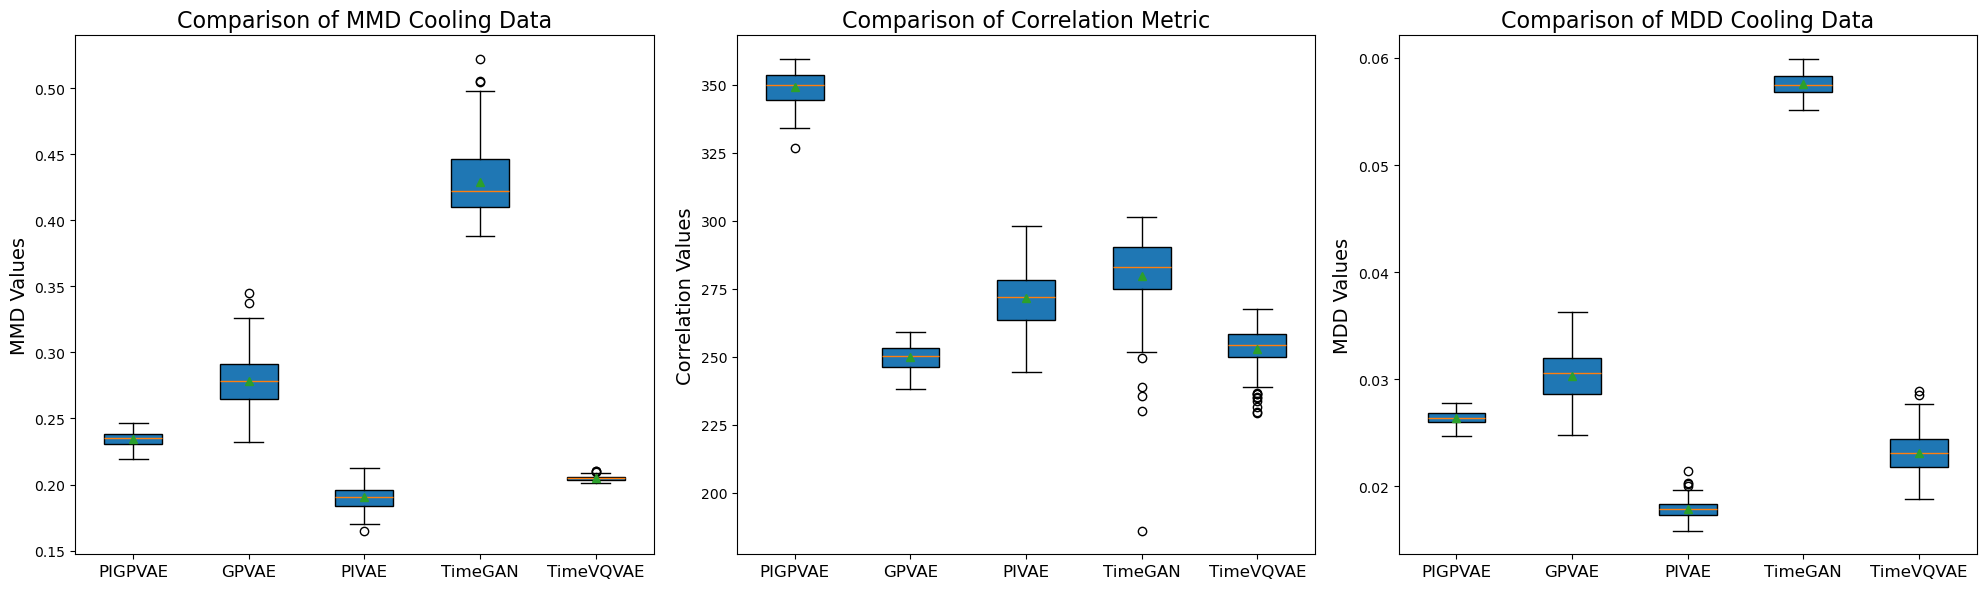

In [21]:
labels = ['PIGPVAE', 'GPVAE', 'PIVAE', 'TimeGAN', 'TimeVQVAE']
# Extract values as lists for each metric
mmd_data = [mmd_tensors[model].tolist() for model in labels]
correlation_data = [correlation_tensors[model].tolist() for model in labels]
mdd_data = [mdd_tensors[model].tolist() for model in labels]

# Combine all metrics into a single list
data_list = [mmd_data, correlation_data, mdd_data]

# Function to create side-by-side box plots 
def plot_side_by_side_independent(data_list, titles, ylabels, xlabels):
    fig, axes = plt.subplots(1, len(data_list), figsize=(20, 6))
    
    for i, data in enumerate(data_list):
        axes[i].boxplot(data, vert=True, patch_artist=True, labels=xlabels[i], showmeans=True)
        axes[i].set_title(titles[i], fontsize=16)
        axes[i].set_xticklabels(xlabels[i], fontsize=12)
        axes[i].set_ylabel(ylabels[i], fontsize=14)
    
    plt.tight_layout()
    plt.show()

# Titles, y-labels, and x-labels for each metric
titles = ['Comparison of MMD Cooling Data', 
          'Comparison of Correlation Metric', 
          'Comparison of MDD Cooling Data']
ylabels = ['MMD Values', 'Correlation Values', 'MDD Values']
xlabels = [['PIGPVAE', 'GPVAE', 'PIVAE', 'TimeGAN','TimeVQVAE'], 
           ['PIGPVAE', 'GPVAE', 'PIVAE', 'TimeGAN', 'TimeVQVAE'], 
           ['PIGPVAE', 'GPVAE', 'PIVAE', 'TimeGAN','TimeVQVAE']]

# Plot all metrics side by side with independent x-axes
plot_side_by_side_independent(data_list, titles, ylabels, xlabels)


In [22]:
# Function to find the two best-performing methods and perform a t-test
def compare_best_methods(data_list, labels, metric_names):
    results = {}

    for metric_idx, data in enumerate(data_list):
        # Compute mean values for each model
        mean_values = [np.mean(model_data) for model_data in data]
        
        # Get indices of the two best models (smallest mean values)
        sorted_indices = np.argsort(mean_values)[:2]
        best_model_1, best_model_2 = labels[sorted_indices[0]], labels[sorted_indices[1]]
        
        # Perform Welch’s t-test
        t_stat, p_value = stats.ttest_ind(data[sorted_indices[0]], data[sorted_indices[1]], equal_var=False)

        # Store results
        results[metric_names[metric_idx]] = {
            "Best Models": (best_model_1, best_model_2),
            "Mean Values": (mean_values[sorted_indices[0]], mean_values[sorted_indices[1]]),
            "t-statistic": t_stat,
            "p-value": p_value
        }

    return results

# Define metric names
metric_names = ["MMD", "Correlation", "MDD"]

# Run comparison and t-tests
results = compare_best_methods(data_list, labels, metric_names)

# Print results
for metric, res in results.items():
    print(f"\nMetric: {metric}")
    print(f"Best Models: {res['Best Models'][0]} ({res['Mean Values'][0]:.6f}), {res['Best Models'][1]} ({res['Mean Values'][1]:.6f})")
    print(f"T-statistic: {res['t-statistic']:.6f}, P-value: {res['p-value']:.6f}")


Metric: MMD
Best Models: PIVAE (0.190228), TimeVQVAE (0.204894)
T-statistic: -17.785194, P-value: 0.000000

Metric: Correlation
Best Models: GPVAE (249.794776), TimeVQVAE (252.867059)
T-statistic: -3.140385, P-value: 0.002015

Metric: MDD
Best Models: PIVAE (0.017892), TimeVQVAE (0.023134)
T-statistic: -22.622164, P-value: 0.000000


/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_2758/3046635010.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, vert=True, patch_artist=True, labels=xlabels[i], showmeans=True)
/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_2758/3046635010.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, vert=True, patch_artist=True, labels=xlabels[i], showmeans=True)
/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_2758/3046635010.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, vert=True, patch_artist=True, labels=xlabels[

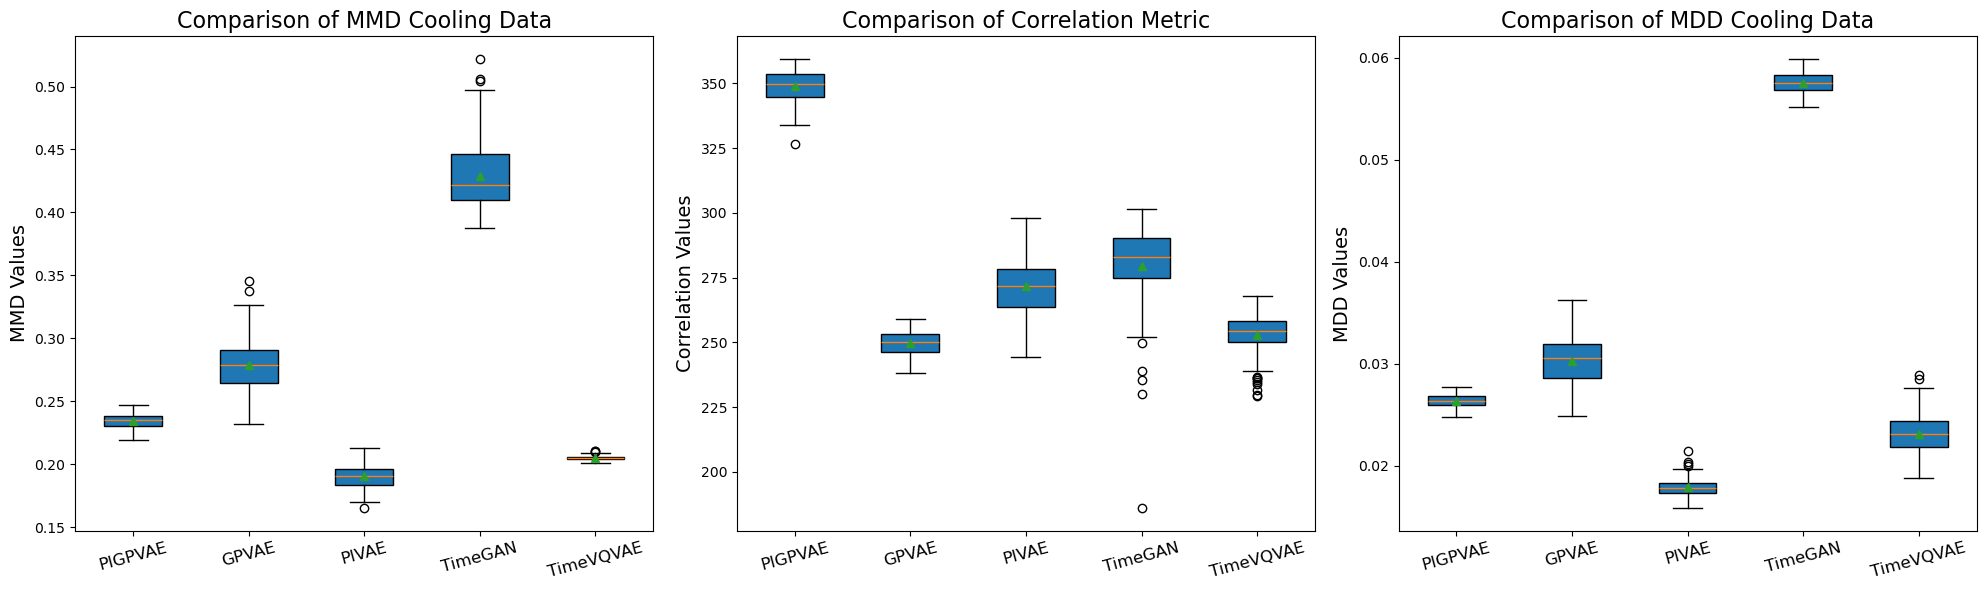

In [23]:
# Update labels to include TimeVQVAE
labels = ['PIGPVAE', 'GPVAE', 'PIVAE', 'TimeGAN', 'TimeVQVAE'
         ]

# Extract values as lists for each metric
mmd_data = [mmd_tensors[model].tolist() for model in labels]
correlation_data = [correlation_tensors[model].tolist() for model in labels]
mdd_data = [mdd_tensors[model].tolist() for model in labels]

# Combine all metrics into a single list
data_list = [mmd_data, correlation_data, mdd_data]

# Function to create side-by-side box plots with independent x-axes for each metric
def plot_side_by_side_independent(data_list, titles, ylabels, xlabels):
    fig, axes = plt.subplots(1, len(data_list), figsize=(20, 6))
    
    for i, data in enumerate(data_list):
        axes[i].boxplot(data, vert=True, patch_artist=True, labels=xlabels[i], showmeans=True)
        axes[i].set_title(titles[i], fontsize=16)
        axes[i].set_xticklabels(xlabels[i], fontsize=12, rotation=15)
        axes[i].set_ylabel(ylabels[i], fontsize=14)
    
    plt.tight_layout()
    plt.show()

# Titles, y-labels, and x-labels for each metric
titles = ['Comparison of MMD Cooling Data', 
          'Comparison of Correlation Metric', 
          'Comparison of MDD Cooling Data']
ylabels = ['MMD Values', 'Correlation Values', 'MDD Values']
xlabels = [labels, labels, labels]

# Plot all metrics side by side with independent x-axes
plot_side_by_side_independent(data_list, titles, ylabels, xlabels)


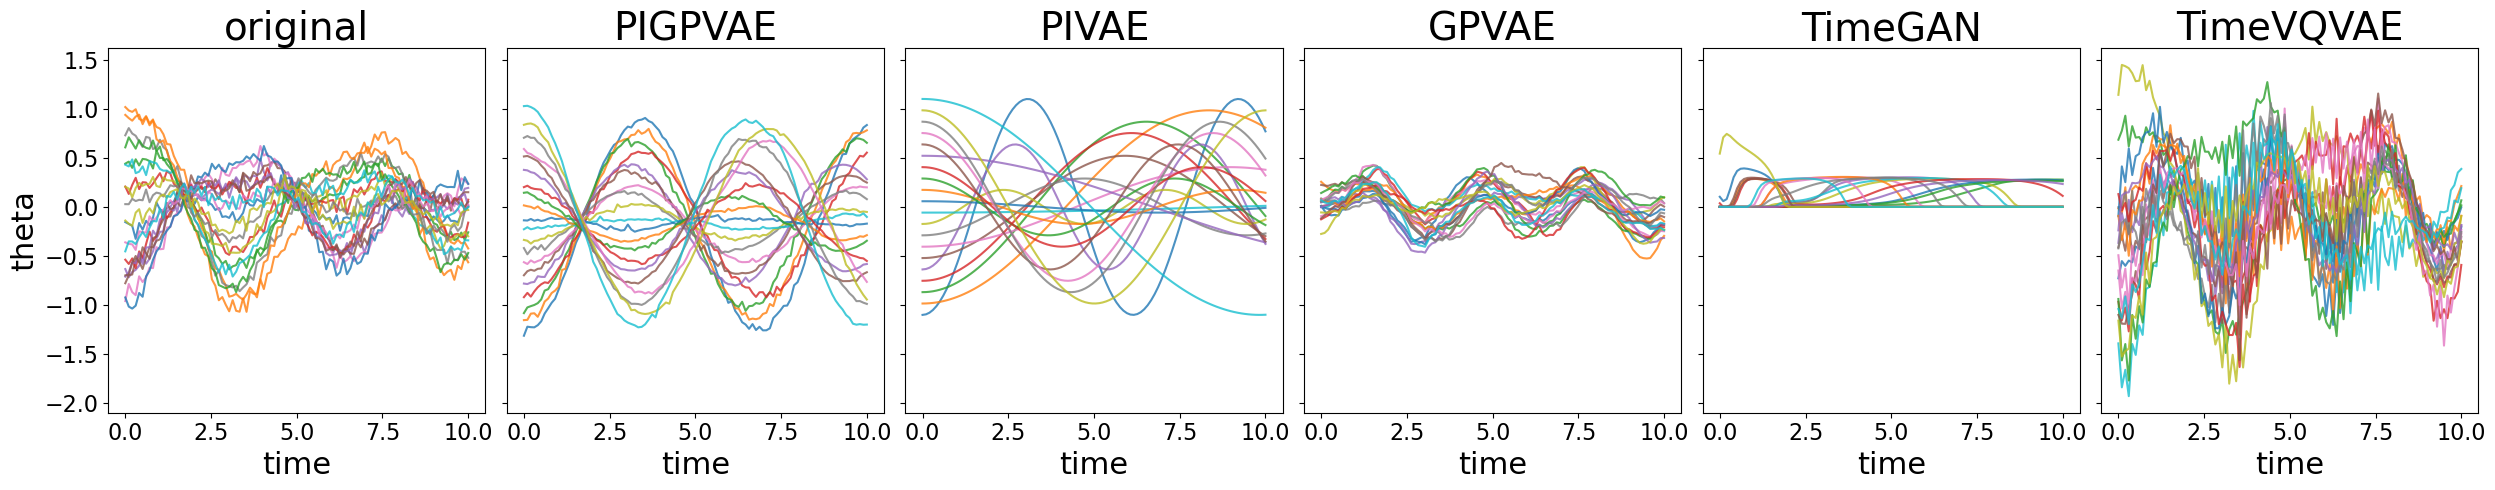

In [24]:
# Update datasets to include TimeVQVAE
datasets = [
    ("original", original_data), 
    ("PIGPVAE", Gd_PIGPVAE), 
    ("PIVAE", Gd_PIVAE), 
    ("GPVAE", Gd_GPVAE), 
    ("TimeGAN", Gd_timeGAN), ("TimeVQVAE", Gd_TimeVQVAE)
]

# Create subplots for each dataset
fig, axes = plt.subplots(1, len(datasets), figsize=(25, 5), sharey=True)

# Define font size
title_fontsize = 28
label_fontsize = 22
tick_fontsize = 16

# Plot each dataset
for idx, (ax, (title, data)) in enumerate(zip(axes, datasets)):
    for ts in data:
        ax.plot(t_uni, ts.numpy(), alpha=0.8)
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel("time", fontsize=label_fontsize)
    
    # Set y-axis label only for the first plot
    if idx == 0:
        ax.set_ylabel("theta", fontsize=label_fontsize)
    
    # Increase font size for tick labels
    ax.tick_params(axis='both', labelsize=tick_fontsize)

# Adjust layout and save the plot
plt.tight_layout()
# plt.savefig("figs/heating_visual_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()


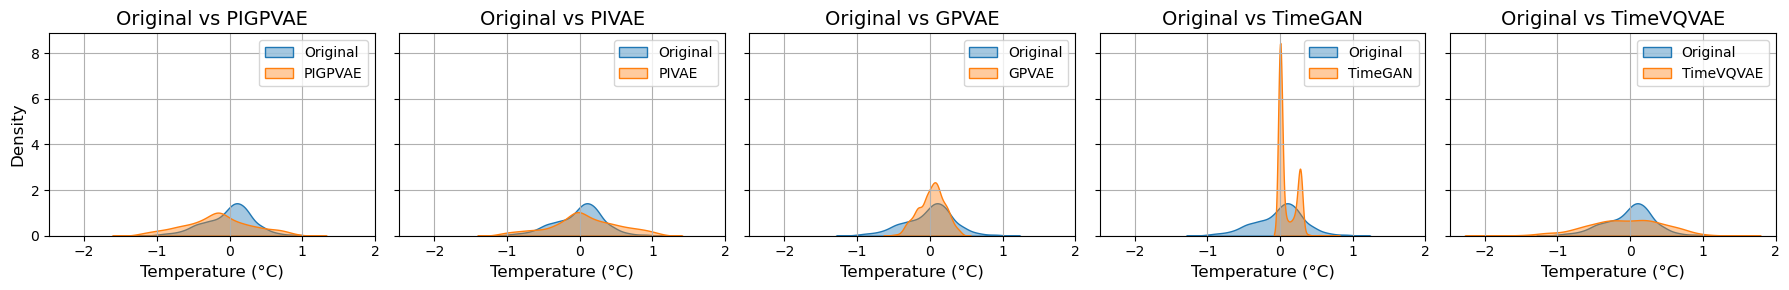

In [25]:
# Update datasets to include TimeVQVAE
datasets = [
    ("PIGPVAE", Gd_PIGPVAE),
    ("PIVAE", Gd_PIVAE),
    ("GPVAE", Gd_GPVAE),
    ("TimeGAN", Gd_timeGAN) ,("TimeVQVAE", Gd_TimeVQVAE)
]

# Flatten the datasets for density plotting
original_flattened = original_data.flatten().numpy()
flattened_data = {name: data.flatten().numpy() for name, data in datasets}

# Plot configurations
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 3), sharex=True, sharey=True)
axes = axes.flatten()

# Generate each comparison plot
for i, (name, data) in enumerate(flattened_data.items()):
    sns.kdeplot(original_flattened, label="Original", fill=True, alpha=0.4, ax=axes[i])
    sns.kdeplot(data, label=name, fill=True, alpha=0.4, ax=axes[i])
    axes[i].set_xlabel("Temperature (°C)", fontsize=12)
    if i == 0:
        axes[i].set_ylabel("Density", fontsize=12)
    axes[i].legend(fontsize=10)
    axes[i].grid(True)
    axes[i].set_title(f"Original vs {name}", fontsize=14)

# Adjust layout
plt.tight_layout()
plt.savefig("figs/pendulum_densities.pdf", format="pdf", bbox_inches="tight")
plt.show()
